# Fashion MNIST Neural Network

Undertaking a classification task, the aim of this project is to develop skills in building neural networks from scratch, image preprocessing, and data augmentation. The dataset used is the Fashion MNIST dataset, which requires classifying instances into one of 10 different classes representing different clothing articles.

The key learning goals of this project understanding backpropagation, loss, training loop, and gradients. Nevertheless, other features will be added that will develop other skills as well.

**Main Objectives**:
- <u>Importing the Data</u>
- <u>Train/val/test split</u>
- <u>Exploratory Data Analysis (EDA) and Visualization</u>
- Data Augmentation
- <u>Preprocessing the Data</u>
- <u> Creating TensorDatasets and DataLoaders</u>
- <u>Building the model</u>
- <u>Creating the Training Loop</u>
  - <u>Add accuracy metric</u>
- <u>Hyperparameter Tuning</u>
  - <u>Add new layers (batch normalization, dropout, etc.)</u>
- <u>Test set evaluation</u>
- Metrics for performance - F1 score, precision, recall, confusion_matrix.
- Finding out what kind of images the model's most confident wrong and correct predictions corresponded to, as well as it's most uncertain predictions.

**Extra**:
- <u>Implement a **Neural Network** from scratch.</u>
- <u>The network must have 1 input layer, 1 hidden layers, and an output layer.</u>
- <u>Implement the forward propagation and backpropagation algorithms.</u>
- <u>Use mini-batch gradient descent.</u>
- <u>Implement the Adam optimizer</u>, dropout, and layer normalization.
- Add zerograd
- Regularization with weight decay.
- <u>Softmax + Categorical Cross-Entropy</u>
- Early Stopping
- Learning rate scheduler and momentum
- Visualize loss curves
- <u>Implement ReLU</u>
- Modular design: Linear, ReLU, Dropout, and Softmax as separate classes.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd

## Neural Network Implementation

The implementation of a non-modular **Neural Network**. This neural network will consist of an input layer, a hidden layers, and an output layer. Forward pass and backpropagation will be based on this model architecture, but this will change with the modular setup.

Mini-batch gradient descent with Adam will be used for optimization, while dropout and weight decay will be used as regularization.

Early stopping and a learning rate scheduler be used to help convergence. Layer normalization will be added as well.

Lastly, the softmax and ReLU activation functions have been implemented.

###**Forward Propagation and Backpropagation**
For a single datapoint, here are the forward propagation and backpropagation algorithms:

**Forward Propagation** (datapoint):
$$m = W^{(1)}x + b^{(1)}$$
$$h = ReLU(m)$$
$$z = W^{(2)}h + b^{(2)}$$
$$y = softmax(z)$$
$$L = L_{CE}(y, t)$$<br>

**Backpropagation** (datapoint):
$$\overline{z}=y-t$$
$$\overline{W^{(2)}}=\overline{z}(h)^T$$
$$\overline{b^{(2)}}=\overline{z}$$
$$\overline{H}=\overline{z}W^{(2)}$$
$$\overline{M}=\overline{h}*ReLU'(m)$$
$$\overline{W^{(1)}}=\overline{m}(x)^T$$
$$\overline{b^{(1)}}=\overline{m}$$

For a batch, the algorithms are formulated as follows:

**Forward Propagation**:
$$M = X(W^{(1)})^T+b^{(1)}$$
$$H = ReLU(M)$$
$$Z = H(W^{(2)})^T+b^{(2)}$$
$$Y = softmax(Z)$$
$$E = \frac{1}{N}\sum_{i}L_{CE}(y^{(i)}, t^{(i)})$$

**Backpropagation:**
$$\overline{Z}=\frac{1}{N}(Y-T)$$
$$\overline{W^{(2)}}=(\overline{Z})^TH$$
$$\overline{b^{(2)}}=(\overline{Z})^T1$$
$$\overline{H}=\overline{Z}W^{(2)}$$
$$\overline{M}=\overline{H}*ReLU'(M)$$
$$\overline{W^{(1)}}=(\overline{M})^TX$$
$$\overline{b^{(1)}}=(\overline{M})^T1$$<br>

### **Adam**
The **Adam** (Adaptive Moment Estimation) optimizer works by combining the concepts of momentum and RMSprop for more efficient optimization. The momentum term $m_t$ is an exponential weighted moving average of past gradients that is recursively updated and accelerates convergence, preventing the model from being stuck on local minima. High and consistent gradients will cause the larger parameter updates and faster movement in that direction (acceleration). Small and noisy updates cause the updating to become smaller and more cautious. RMSprop also has an exponential weighted moving average, $v_t$, but of squared gradients, overcoming the problem of diminishing learning rates often found in adaptive learning methods. The following formulas are relevant to Adam:

**First moment estimate**: $m_t=β_1m_{t-1} + (1-β_1)\frac{∂L}{∂w_t}$<br>
**Second moment estimate**: $v_t=β_2v_{t-1} + (1-β_2)(\frac{∂L}{∂w_t})^2$

Bias correction as $m_t$ and $v_t$ are initialized to 0 and are biased to it. <br>
$\hat{m_t}=\frac{m_t}{1-β_1^t}$ and $\hat{v_t}=\frac{v_t}{1-β_2^t}$

The final update rule is (e is a small value to prevent division by 0):
$$w_{t+1}=w_t+α\frac{\hat{m_t}}{\sqrt{\hat{v_t}}+e}$$

The advantage of Adam is that each parameter has an adaptive learning rate based on the magnitudes and directions of past gradients, helping to overcome any local minima in the training process.<br>

### **Weight Initialization and Gradient Clipping**

In order to deal with exploding gradients, the weights need to be initialized correctly depending on the activation functions and the gradients need to be clipped. For weight initialization, if the ReLU activation function is used, He/Kaiming initialization is required for the weights, and. if sigmoid or softmax, Xavier initialization.

**Xavier Initialization**:<br>
$x = \sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$ and W ~ Uniform(-x, x) <br>

**He/Kaiming Initialization**:<br>
W ~ N(0, $\sqrt{\frac{2}{n}}$)

For gradient clipping, a norm-based technique was used which checks if the norm of the gradieints is above a certain threshold. If it is, clip those gradients by setting them equal to,
$g = threshold*\frac{g}{\|g\|}$

This prevents gradients from becoming excessively large. <br>

### **Learning Rate Scheduler**
**To do**

In [49]:
class NeuralNetwork():
  """
  This is a custom implementation of a neural network with an input layer, a hidden layers, and an output layer.

  Parameters:
  - self.dropout
  - self.learning_rate:
  - self.h: number of units in first hidden layer
  - self.regularization: specify the kind of regularization (TO DO)
  - self.lamb: the regularization strength
  - self.batch_size: the mini-batch size
  - self.momentum:
  - self.epochs: the number of epochs to train for
  - self.W1: the weights for the first hidden layer
  - self.W2: the weights for the second hidden layer
  - self.b1: the bias for the first hidden layer
  - self.b2: the bias for the second hidden layer
  - self.H: stores the value of the second hidden layer for backprop
  - self.M: stores the value of the first hidden layer for backprop

  """
  def __init__(self, dropout=0.8, learning_rate=0.01, h1=64, regularization=None, lamb=0.2, batch_size=32, epochs=20, clipping=1.0, B1=0.9, B2=0.999, optimizer="None"):
    self.W1 = None
    self.W2 = None
    self.b1 = None
    self.b2 = None
    self.batch_size = batch_size
    self.dropout = dropout
    self.clipping = clipping
    self.alpha = learning_rate
    self.regularization = regularization
    self.lamb = lamb
    self.h1 = h1 # no. of units in the hidden layer
    self.epochs = epochs
    self.H = None # hidden layer
    self.M = None # input layer
    self.optimizer=optimizer

    ## For Adam
    # Betas
    self.B1 = B1
    self.B2 = B2
    # Recursive
    self.mt = []
    self.vt = []

    # Bias-corrected
    self.mt_b = []
    self.vt_b = []

    self.t = 0 # current time step


  def fit(self, X, T):
    num_classes = 10
    N = X.shape[0]

    # Convert to numpy
    if isinstance(X, pd.DataFrame):
      X = X.values
    else:
      X = X

    if isinstance(T, pd.DataFrame):
      T = T.values
    else:
      T = T

    # std for he initialization
    c1 = self.he_initialization(X.shape[0])

    # constant for xavier initialization
    c2 = self.xavier_initialization(self.h1, T.shape[1])

    # Weight initialization
    self.W1 = np.random.normal(loc=0, scale=c1, size=(self.h1, X.shape[1]))
    self.W2 = np.random.uniform(low=-c2, high=c2, size=(num_classes, self.h1))
    self.b1 = np.zeros((self.h1, 1)).flatten()
    self.b2 = np.zeros((10, 1)).flatten()


    # Forward propagation -- add training loop here
    for epoch in range(self.epochs):
      random_indices = np.random.permutation(N)

      X_shuffle = X[random_indices]
      T_shuffle = T[random_indices]

      batches = self.mini_batch(T_shuffle, X_shuffle, N)
      total_loss = 0
      n_correct = 0

      # Get mini-batches for training
      for key, value in batches.items():
        x_batch = value[0]
        t_batch = value[1]

        # Forward propagation
        z_batch, y_batch = self.forward_prop(x_batch)

        # One-hot true values
        t_ohe_batch = self.one_hot(t_batch)

        # For Accuracy
        y_batch_preds = np.argmax(y_batch, axis=1)
        n_correct += np.sum((y_batch_preds == t_batch.flatten()).astype(np.float64))

        # Compute loss
        loss = self.compute_loss(y_batch, t_ohe_batch) # pass preds + one-hot targets
        total_loss += loss

        # Backpropagate loss
        grads = self.backpropagation(x_batch, y_batch, t_ohe_batch, loss) # pass preds + one-hot targets

        # Clip gradients
        W1_bar, W2_bar, b1_bar, b2_bar = self.norm_gradient_clipping(grads)

        # Adam (Adaptive Moment Estimation) optimizer
        self.Adam_optimizer(W1_bar, W2_bar, b1_bar, b2_bar)

        # Gradient descent to update parameters
        self.gradient_descent(W1_bar, W2_bar, b1_bar, b2_bar)

      # Calculate epoch accuracy and loss
      epoch_accuracy = n_correct / N
      epoch_loss = (total_loss / len(batches)).flatten()

      print("The training loss at epoch {0} is {1:.4f}".format(epoch, epoch_loss[0]))
      print("The training accuracy at epoch {0} is {1:.4f}".format(epoch, epoch_accuracy*100))


  def forward_prop(self, X):
    # Forward pass
    M = X@(self.W1.T) + self.b1
    H = self.relu(M)
    Z = H@(self.W2.T) + self.b2
    Y = self.softmax(Z)

    # Store M and H
    self.H = H
    self.M = M

    return Z, Y

  def backpropagation(self, X, Y, T, loss):
    grads = []
    N = X.shape[0]

    # Backpropagation
    Z_bar = (1/N)*(Y - T)
    W2_bar = (Z_bar.T)@self.H
    b2_bar = Z_bar
    H_bar = (Z_bar)@self.W2
    M_bar = H_bar*self.relu_derivative(self.M)
    W1_bar = (M_bar.T)@X
    b1_bar = M_bar

    grads.extend([Z_bar, W2_bar, b2_bar, H_bar, M_bar, W1_bar, b1_bar])

    return grads

  def norm_gradient_clipping(self, gradients):
    clipped = []
    for grad in gradients:
      norm = np.sqrt(np.sum(grad**2))
      if norm >= self.clipping:
        grad = self.clipping*grad/norm

      clipped.append(grad)

    return clipped[5], clipped[1], clipped[6], clipped[2]

  def gradient_descent(self, W1_bar, W2_bar, b1_bar, b2_bar):
    # without Adam
    if self.optimizer == "None":
      self.W1 = self.W1 - self.alpha*W1_bar
      self.W2 = self.W2 - self.alpha*W2_bar
      self.b1 = self.b1 - self.alpha*np.sum(b1_bar, axis=0)
      self.b2 = self.b2 - self.alpha*np.sum(b2_bar, axis=0)

    # with Adam
    elif self.optimizer == "Adam":
      self.W1 = self.W1 - self.alpha*self.mt_b[0]/(np.sqrt(self.vt_b[0]+1e-10))
      self.W2 = self.W2 - self.alpha*self.mt_b[1]/(np.sqrt(self.vt_b[1]+1e-10))
      self.b1 = self.b1 - self.alpha*self.mt_b[2]/(np.sqrt(self.vt_b[2]+1e-10))
      self.b2 = self.b2 - self.alpha*self.mt_b[3]/(np.sqrt(self.vt_b[3]+1e-10))


  def one_hot(self, y):
    y_ohe = np.zeros(shape=(y.shape[0], 10))
    instances_for_indexing = np.arange(y.shape[0])
    y_ohe[instances_for_indexing, y.flatten()] = 1
    return y_ohe

  def compute_loss(self, y, t):
    # get N
    N = t.shape[0]
    y_clipped = np.clip(y, 1e-9, 1-1e-9) # to avoid nan in the loss

    # Computes cost - categorical cross-entropy
    return - np.sum((t * np.log(y_clipped))) / N

  def Adam_optimizer(self, W1_bar, W2_bar, b1_bar, b2_bar):
    weight_grads = [W1_bar, W2_bar, np.sum(b1_bar, axis=0), np.sum(b2_bar, axis=0)]

    self.t += 1 # update time step

    if self.mt == [] and self.vt == []:
      for i in range(len(weight_grads)):
        self.mt.append(np.zeros_like(weight_grads[i]))
        self.vt.append(np.zeros_like(weight_grads[i]))
        self.mt_b.append(np.zeros_like(weight_grads[i]))
        self.vt_b.append(np.zeros_like(weight_grads[i]))

    for i in range(len(weight_grads)):
      # First moment
      self.mt[i] = self.B1*self.mt[i] + (1-self.B1)*weight_grads[i]

      # Second moment
      self.vt[i] = self.B2*self.vt[i] + (1-self.B2)*(weight_grads[i]**2)

      # Bias corrections
      self.mt_b[i] = self.mt[i]/(1-self.B1**self.t)
      self.vt_b[i] = self.vt[i]/(1-self.B2**self.t)

  def xavier_initialization(self, n_inputs, n_outputs):
    return np.sqrt(6/(n_inputs+n_outputs))

  def he_initialization(self, n_inputs):
    return np.sqrt(2/n_inputs)

  def predict(self, X_new):
    M = X_new@(self.W1.T) + self.b1
    H = self.relu(M)
    Z = H@(self.W2.T) + self.b2
    Y = self.softmax(Z)
    return np.argmax(Y, axis=1)

  def relu_derivative(self, o):
    return np.piecewise(o, [o <= 0, o > 0], [0, 1])

  def relu(self, o):
    return np.maximum(0, o)

  def softmax(self, o):
    # To prevent overflow
    o_max = np.max(o, axis=1).reshape(-1, 1)
    o_shifted = o - o_max

    # Softmax function implementation, the keepdims is used for broadcasting purposes.
    z =  np.exp(o_shifted) / np.sum(np.exp(o_shifted), axis=1, keepdims=True)
    return z

  def mini_batch(self, t, X, N):
    batches = {}
    n_batches = N // self.batch_size
    # Create batches
    for i in range(n_batches):
        batches[i] = [X[i*self.batch_size:(i+1)*self.batch_size], t[i*self.batch_size:(i+1)*self.batch_size]]

    # Last batch should be compiled into its own batch, even if it's less than batch size
    if N % self.batch_size != 0 :
        batches[n_batches] = [X[n_batches*self.batch_size:], t[n_batches*self.batch_size:]]

    return batches

  def layer_normalization(self):
    pass

  def weight_decay(self):
    pass

  def learning_rate_scheduler(self):
    pass

  def batch_normalization(self):
    pass

  def dropout(self):
    pass



In [50]:
model_implemented = NeuralNetwork(optimizer="Adam")
model_implemented.fit(X_train_scale, y_train)

The training loss at epoch 0 is 1.1971
The training accuracy at epoch 0 is 73.4533
The training loss at epoch 1 is 0.7939
The training accuracy at epoch 1 is 79.5067
The training loss at epoch 2 is 0.6762
The training accuracy at epoch 2 is 81.9867
The training loss at epoch 3 is 0.6371
The training accuracy at epoch 3 is 84.0133
The training loss at epoch 4 is 0.6807
The training accuracy at epoch 4 is 83.0800
The training loss at epoch 5 is 0.5886
The training accuracy at epoch 5 is 85.3733
The training loss at epoch 6 is 0.5962
The training accuracy at epoch 6 is 85.1467
The training loss at epoch 7 is 0.5561
The training accuracy at epoch 7 is 85.8000
The training loss at epoch 8 is 0.4748
The training accuracy at epoch 8 is 87.5067
The training loss at epoch 9 is 0.5061
The training accuracy at epoch 9 is 87.8933
The training loss at epoch 10 is 0.4695
The training accuracy at epoch 10 is 88.8933
The training loss at epoch 11 is 0.4769
The training accuracy at epoch 11 is 88.9200


## Modular Implementation of a Neural Network

Divides the previous implementation k into several classes that can be combined to form the entire network. The main purpose of this is start writing modular code and create reusable classes for further projects.

## Importing the Data

In [5]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projects/fashion_mnist/fashion-mnist_test.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projects/fashion_mnist/fashion-mnist_train.csv")

In [6]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data.iloc[:, 1:], train_data["label"], test_size=0.25, train_size=0.75, shuffle=True, stratify=train_data["label"])


In [8]:
# Reset indices
X_train = X_train.reset_index()
X_val = X_val.reset_index()
y_train = y_train.reset_index()
y_val = y_val.reset_index()

In [9]:
X_test = test_data.drop("label", axis=1)
y_test = test_data["label"]

In [10]:
# Drop redundant index columns
X_train = X_train.drop("index", axis=1)
X_val = X_val.drop("index", axis=1)
y_train = y_train.drop("index", axis=1)
y_val = y_val.drop("index", axis=1)

## Data Preprocessing

Standardize features for training

In [11]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train)
X_val_scale = standard_scaler.transform(X_val)
X_test_scale = standard_scaler.transform(X_test)

## Creating Tensor Datasets and Data Loaders

In [12]:
# Create Tensor Datasets
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_scale, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_scale, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_scale, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

In [13]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Exploratory Data Analysis (EDA)

To begin with, check the distribution of classes and the size of the images.

In [14]:
torch.bincount(train_dataset.tensors[1].squeeze()), len(torch.bincount(train_dataset.tensors[1].squeeze()))

(tensor([750, 750, 750, 750, 750, 750, 750, 750, 750, 750]), 10)

The class distributions are entirely even, there are 10 classes and each contains 750 instances.

In [15]:
train_dataset.tensors[0].shape

torch.Size([7500, 784])

There are 7500 total instances with 784 features each. Each feature represents a pixel on a 28x28 image. Now, to visualize the images of a few classes.

In [16]:
images = train_dataset.tensors[0].reshape(7500, 28, 28)

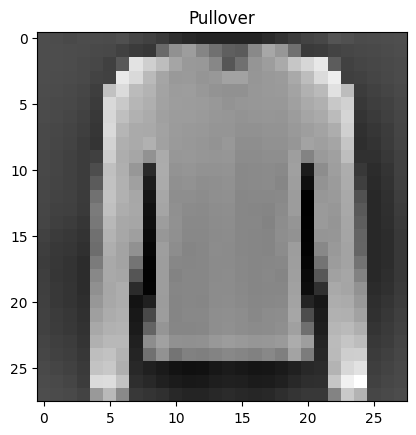

In [17]:
plt.imshow(images[y_train[y_train["label"]==2].index[4], :, :], cmap="grey")
plt.title("Pullover")
plt.show()

In [18]:
class_names = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

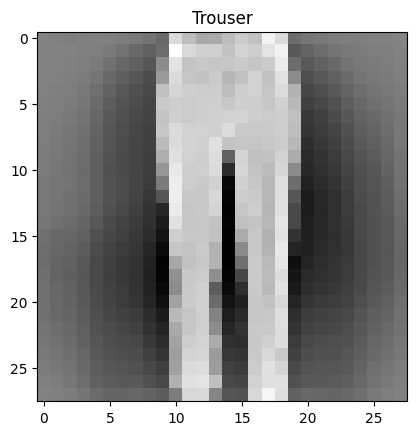

In [19]:
plt.imshow(images[y_train[y_train["label"]==1].index[2], :, :], cmap="grey")
plt.title("Trouser")
plt.show()

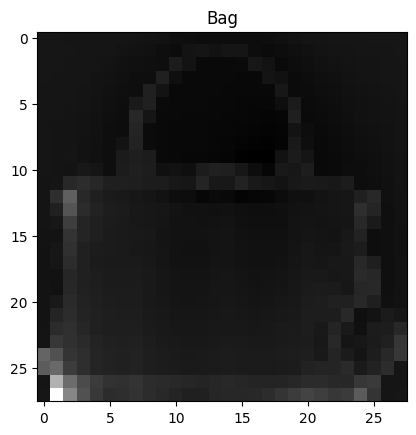

In [20]:
plt.imshow(images[y_train[y_train["label"]==8].index[4], :, :], cmap="grey")
plt.title("Bag")
plt.show()

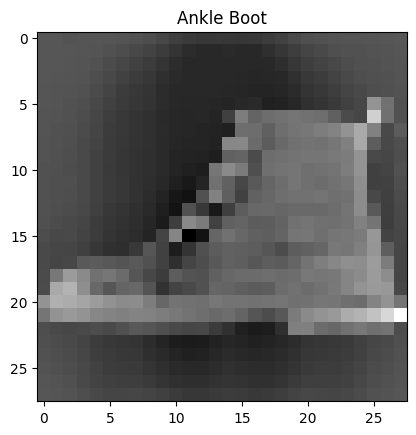

In [21]:
plt.imshow(images[y_train[y_train["label"]==9].index[2], :, :], cmap="grey")
plt.title("Ankle Boot")
plt.show()

After having visualized a few images of the fashion MNIST training data, it is now possible to proceed to data augmentation, preprocessing, and training.

## Data Augmentation

Common techniques for augmenting images are the following:
- tbd

## Building the Model, Creating the Training Loop, and Hyperparameter Tuning

Builds a class-based model and its training loop, and contains the results of hyperparameter tuning on the validation set.

In [22]:
# Model class
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 16)
    self.dropout = nn.Dropout(p=0.2)
    self.batchnorm = nn.BatchNorm1d(num_features=784, momentum=0.1)
    self.fc2 = nn.Linear(16, 8)
    self.fc3 = nn.Linear(8, 10)

  def forward(self, x):
    x = self.batchnorm(x)
    x = self.dropout(x)
    x = nn.functional.relu(self.fc1(x))
    x = nn.functional.relu(self.fc2(x))
    x = self.fc3(x) # CrossEntropy loss already applies softmax

    return x

In [23]:
import torch.optim as optim
# Training loop
epochs = 7
model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001, betas=(0.9, 0.999))

for epoch in range(epochs):
  epoch_loss = 0
  val_epoch_loss = 0
  n_correct = 0
  n_val_correct = 0
  for data in train_dataloader:
    # Set gradients to zero
    optimizer.zero_grad()

    # Gets batches
    feature, target = data

    # Predictions
    preds = model(feature)

    # Calculate loss for batch
    loss = criterion(preds, target.squeeze())

    # Calculating accuracy
    preds_labels = torch.argmax(preds, dim=1).reshape(target.shape[0], 1)
    values = (preds_labels == target).float()
    n_correct += torch.sum(values)

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    epoch_loss += loss

  for val_data in val_dataloader:
    with torch.no_grad():
      val_feature, val_target = val_data

      val_preds = model(val_feature)

      val_loss = criterion(val_preds, val_target.squeeze())

      val_preds_labels = torch.argmax(val_preds, dim=1).reshape(val_target.shape[0], 1)

      val_values = (val_preds_labels == val_target).float()

      n_val_correct += torch.sum(val_values)

      val_epoch_loss += val_loss

  model.train()

  n_total = 7500
  n_val_total = 2500
  print("The loss for epoch {0} is {1}.".format(epoch+1, epoch_loss.item() / len(train_dataloader)))
  print("The accuracy for epoch {0} is {1:.2f}".format(epoch+1, 100*(n_correct/n_total)))
  print("The validation loss for epoch {0} is {1}.".format(epoch+1, val_epoch_loss.item() / len(val_dataloader)))
  print("The validation accuracy for epoch {0} is {1:.2f}".format(epoch+1, 100*(n_val_correct/n_val_total)))
  print("-------------------------------------------------------------")
  print("\n")

  # Calculate validation loss + accuracy
  model.eval()



The loss for epoch 1 is 1.3311835106382979.
The accuracy for epoch 1 is 52.84
The validation loss for epoch 1 is 0.8912966764425929.
The validation accuracy for epoch 1 is 66.52
-------------------------------------------------------------


The loss for epoch 2 is 0.6417485663231383.
The accuracy for epoch 2 is 77.47
The validation loss for epoch 2 is 0.5984229075757763.
The validation accuracy for epoch 2 is 78.20
-------------------------------------------------------------


The loss for epoch 3 is 0.514309010607131.
The accuracy for epoch 3 is 81.49
The validation loss for epoch 3 is 0.5437259432635729.
The validation accuracy for epoch 3 is 80.56
-------------------------------------------------------------


The loss for epoch 4 is 0.46626882350191157.
The accuracy for epoch 4 is 82.99
The validation loss for epoch 4 is 0.542787141437772.
The validation accuracy for epoch 4 is 81.36
-------------------------------------------------------------


The loss for epoch 5 is 0.4337566

For a feedforward neural network with an input layer, 2 hidden layers with 64 and 32 neurons respectively, and an output layer, a training accuracy of 97-98% was reached after 20 epochs, while the validation accuracy remains between 84-85%. This huge gap between the training and validation accuracy indicates that the model is overfitting the training data.

To remedy this, the following strategies will be attempted:
- Batch Normalization
- Dropout
- Weight Decay
- Momentum

Experimenting with these values did not reduce the validation loss by much, and so the number of layers, neurons per hidden layer, and epochs had to be reduced. The final architecture looked as follows:
- **Input layer**: 784 units (flattened 28 x 28)
- **Hidden layer**: Linear(784 -> 16), followed by BatchNorm1d (momentum = 0.1), Dropout (p = 0.2) and ReLU activation.
- **Hidden layer**: Linear(16 -> 8) with ReLU activation.
- **Output layer**: (8 -> 10) with softmax application applied in CrossEntropyLoss function.

Training lasted for 7 epochs. The validation accuracy was around 83-84%%, and so decreased marginally, while the training accuracy decreased to around 87-88%, which is huge. The model no longer overfits or does so only slightly based on the gap between the training and validation accuracies.

## Test Set Evaluation

In [24]:
model.eval()
total_loss = 0
n_correct = 0
for data in test_dataloader:
  test_feature, test_target = data
  test_preds = model(test_feature)
  test_loss = criterion(test_preds, test_target.squeeze())
  total_loss += test_loss

  test_preds_labels = torch.argmax(test_preds, dim=1)
  n_correct += torch.sum((test_preds_labels == test_target).float())

test_accuracy = n_correct / len(test_dataset)
test_loss = total_loss / len(test_dataloader)

print("The test accuracy is {0:.4f}".format(test_accuracy*100))
print("The test loss is {0}".format(test_loss))

The test accuracy is 82.9450
The test loss is 0.493802547454834


The test accuracy generally ranges from 82.5-84%, which is standard for a feedforward neural network.

## Other Metrics

## Analysis of Model Predictions

## Testing of Implementations